# Imports

In [15]:
%matplotlib inline
%config IPCompleter.greedy=True
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from sklearn import preprocessing
import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Lambda, Cropping2D
from tensorflow.keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions, VGG19
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import cv2 as cv

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import re

# K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# Preprocessing image

In [16]:
def preprocess_img(image):
    init_height, init_width, _ = image.shape
    YUV_image = cv.cvtColor(image, cv.COLOR_RGB2YUV_I420)
    YUV_height, YUV_width = YUV_image.shape
    process_height = int((YUV_height - init_height) / 2)
    YUV_image = YUV_image[init_height + int(process_height / 2):init_height +
                          process_height, 0:int(init_width / 2)]
    canny_image = cv.Canny(YUV_image, 10, 60)
    
    return canny_image

# Loading images

 64%|████████████████████████████████████████████████▋                           | 1537/2397 [00:10<00:06, 143.03it/s]

Skipped bad image: vide117_068_100.png
Could not find a format to read the specified file in mode 'i'


 75%|████████████████████████████████████████████████████████▊                   | 1792/2397 [00:12<00:04, 143.27it/s]

Skipped bad image: vide120_155_054.png
Could not find a format to read the specified file in mode 'i'


 82%|██████████████████████████████████████████████████████████████▍             | 1971/2397 [00:13<00:03, 141.21it/s]

Skipped bad image: vide122_075_048.png
Could not find a format to read the specified file in mode 'i'


100%|████████████████████████████████████████████████████████████████████████████| 2397/2397 [00:17<00:00, 140.10it/s]


Text(0.5, 1.0, '52')

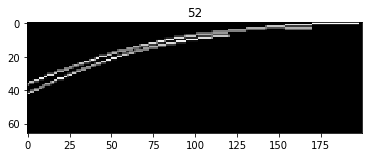

In [17]:
from tqdm import tqdm
images = []
labels = []

path = './data09/'
valid_images = [".jpg",".gif",".png"]

zero_num = 0
center_num = 0
full_num = 0

for f in tqdm(os.listdir(path)):
    try:
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        angle = int(f[-7:-4])        
            
        im = imread(os.path.join(path,f))
        images.append(cv.resize(preprocess_img(im), (200,66)))
        labels.append(angle)
    except Exception as error:
        print('Skipped bad image: %s' % f)
        print(error)
        
plt.imshow(images[20])
plt.title(labels[20])

## Plot some preprocessed images

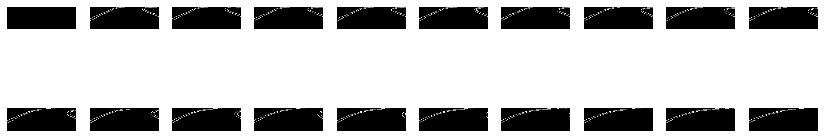

In [18]:
def plot_images(list_images, rows, columns, num_images):
    for index, val in enumerate(list_images[:num_images]):
        plt.subplot(rows,columns,index+1)
        plt.axis('off')
        plt.subplots_adjust(bottom=1, right=2, top=2)
        plt.imshow(val)

plot_images(images, rows=3, columns=10, num_images=20)

## Data distribution

Text(0, 0.5, 'count')

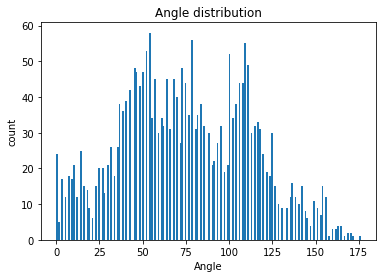

In [19]:
plt.hist(labels, bins=180)
plt.title('Angle distribution')
plt.xlabel('Angle')
plt.ylabel('count')

Most of the data is centered around 75, this is because driving with an angle of 75 is almost driving straight.

# Preprocessing

The data passing trough the CNN must be a numpy array of shape (66, 200, 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)

X_train = np.array(X_train).reshape(len(X_train), 1, 66, 200).transpose(0,2,3,1)
X_test = np.array(X_test).reshape(len(X_test), 1, 66, 200).transpose(0,2,3,1)
y_train = np.array(y_train)
y_test = np.array(y_test)


y_train.shape

(1915,)

## Model

In [21]:
# Early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=5, patience=30)

# Checkpoint callback : If the model improves during an epoch, the model will be saved into a file
checkpoint = ModelCheckpoint("model/nvidia_model_v7.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model = Sequential()

model.add(Dense(3, input_shape=(66, 200, 1)))

model.add(BatchNormalization())

# layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2,2), kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.2))

# layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Conv2D(filters=36, kernel_size=(5, 5), strides=(2,2), kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.2))

# layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2,2), kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.2))

# layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.2))

# layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.2))

# flatten image from 2D to side by side
model.add(Flatten())

model.add(Dense(1164, kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.3))

# layer 6- fully connected layer 1
model.add(Dense(100, kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.3))

# Adding a dropout layer to avoid overfitting. Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50, kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.3))

#layer 8- fully connected layer 1
model.add(Dense(10, kernel_initializer=('RandomUniform')))
model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.20))


#layer 9- fully connected layer 1
model.add(Dense(1))#here the final layer will contain one value as this is a regression problem and not classification
model.add(Activation('linear'))

# the output is the steering angle
# using mean squared error loss function is the right choice for this regression problem
# adam optimizer is used here
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 66, 200, 3)        6         
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 200, 3)        12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)        

## Training the model

In [22]:
batch_size = 64
epochs = 1000

history = model.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[earlystop, checkpoint])

Train on 1532 samples, validate on 383 samples
Epoch 1/1000
1472/1532 [===========================>..] - ETA: 0s - loss: 5384.2746 ETA: 0s - loss: 532
Epoch 00001: val_loss improved from inf to 5529.19645, saving model to model/nvidia_model_v7.hdf5
1532/1532 [==============================] - 2s 1ms/sample - loss: 5300.6714 - val_loss: 5529.1965
Epoch 2/1000
1472/1532 [===========================>..] - ETA: 0s - loss: 2150.4175
Epoch 00002: val_loss improved from 5529.19645 to 2333.04392, saving model to model/nvidia_model_v7.hdf5
1532/1532 [==============================] - 1s 575us/sample - loss: 2124.5505 - val_loss: 2333.0439
Epoch 3/1000
1472/1532 [===========================>..] - ETA: 0s - loss: 1346.6702
Epoch 00003: val_loss improved from 2333.04392 to 1545.11774, saving model to model/nvidia_model_v7.hdf5
1532/1532 [==============================] - 1s 574us/sample - loss: 1334.8717 - val_loss: 1545.1177
Epoch 4/1000
1472/1532 [===========================>..] - ETA: 0s - loss

## Load best model

In [ ]:
model = load_model('model/nvidia_model_v7.hdf5')

## Test model on one new image

Predicted angle: 103
Actual angle: 97


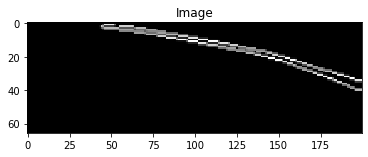

In [23]:
sample = 30

y_pred = model.predict(np.array([X_test[sample]]))
plt.imshow(X_test[sample].reshape(66, 200))
plt.title('Image')
print('Predicted angle: %s' % int(y_pred))
print('Actual angle: %s' % y_test[sample])

## Evaluate model with MSE, MAE and R2

In [24]:
# Evaluatie van het model via de MAE, MSE en de R2-score
y_predicted = model.predict(X_test)

## Mean Absolute Error
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test,y_predicted)
print('MAE = ', MAE)

## Mean Squared Error
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test,y_predicted)
print('MSE = ', MSE)

## coefficient of determination = r2 score
from sklearn.metrics import r2_score

r2 = r2_score(y_test,y_predicted)

print('r2 score = ', r2)


MAE =  13.68824220304076
MSE =  363.35301669641996
r2 score =  0.7154147883063495


## Plot the training loss based on MSE 

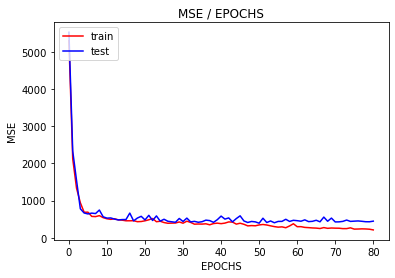

In [25]:
# MAE 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('MSE / EPOCHS')
plt.ylabel('MSE')
plt.xlabel('EPOCHS')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Convert tensorflow to tflite model

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [27]:
open("model/nvidia_model_v7.tflite", "wb").write(tflite_model)

1608104